# **HackaPUCSP: Previsão de Desempenho no ENEM**

## **Importação das bibliotecas e dos dados**

In [1]:
SEED = 3

from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,Q020,Q021,Q022,Q023,Q024,Q025,ID,MF,NU_ANO,CONCEITO
0,3,F,1,1,1,2,2,1.0,0,4322707.0,...,A,A,E,A,B,B,2464336,608.46,2020,C
1,4,M,1,3,1,2,2,1.0,0,3303500.0,...,A,B,B,A,A,A,1983774,362.88,2020,E
2,3,M,1,3,1,2,2,1.0,0,2408102.0,...,A,A,E,A,B,B,1440554,681.82,2020,C
3,2,M,1,3,1,2,2,1.0,0,2306405.0,...,A,A,B,A,A,A,2522015,462.20,2020,E
4,3,F,1,1,1,2,2,1.0,0,3520509.0,...,A,A,D,A,A,B,3274277,506.72,2020,D


Verificando se há itens duplicados

In [4]:
train_data[train_data.duplicated(subset='ID', keep='first')]

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,Q020,Q021,Q022,Q023,Q024,Q025,ID,MF,NU_ANO,CONCEITO


In [5]:
train_data = train_data.set_index('ID')
train_data.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MF,NU_ANO,CONCEITO
ID,,,,,,,,,,,,,,,,,,,,,
2464336,3,F,1,1,1,2,2,1.0,0,4322707.0,...,C,A,A,E,A,B,B,608.46,2020,C
1983774,4,M,1,3,1,2,2,1.0,0,3303500.0,...,B,A,B,B,A,A,A,362.88,2020,E
1440554,3,M,1,3,1,2,2,1.0,0,2408102.0,...,C,A,A,E,A,B,B,681.82,2020,C
2522015,2,M,1,3,1,2,2,1.0,0,2306405.0,...,B,A,A,B,A,A,A,462.20,2020,E
3274277,3,F,1,1,1,2,2,1.0,0,3520509.0,...,B,A,A,D,A,A,B,506.72,2020,D


**Tipo de colunas**

- **Retirar:** ID, NO_MUNICIPIO_ESC, SG_UF_ESC, NO_MUNICIPIO_PROVA, SG_UF_PROVA, NO_MUNICIPIO_PROVA, SG_UF_PROVA, TX_RESPOSTAS_CN, TX_RESPOSTAS_CH, TX_RESPOSTAS_LC, TX_RESPOSTAS_MT, TX_GABARITO_CN, TX_GABARITO_CH, TX_GABARITO_LC, TX_GABARITO_MT

- **Booleanas:** Q018, Q020, Q021, Q023, Q025

- **Categóricas Ordinais:** TP_FAIXA_ETARIA, Q001, Q002, Q006, Q007, Q008, Q009, Q010, Q011, Q012, Q013, Q014, Q015, Q016, Q017, Q019, Q022, Q024

- **Categóricas Nominais:** Q003, Q004, TP_SEXO, CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_LC, CO_PROVA_MT, CO_MUNICIPIO_PROVA, CO_UF_PROVA, CO_MUNICIPIO_ESC, CO_UF_ESC

- **Numéricas:** TP_SIT_FUNC_ESC, IN_TREINEIRO, TP_PRESENCA_CH, NU_NOTA_CH, NU_NOTA_MT, NU_ANO, NU_NOTA_CN, MF, TP_LINGUA, TP_ENSINO, TP_ST_CONCLUSAO, Q005, NU_NOTA_COMP3, TP_PRESENCA_MT, TP_NACIONALIDADE, TP_PRESENCA_CN, NU_NOTA_COMP5, NU_NOTA_REDACAO, TP_DEPENDENCIA_ADM_ESC, TP_ESCOLA, NU_NOTA_COMP1, NU_NOTA_COMP4, TP_ESTADO_CIVIL, TP_COR_RACA, TP_STATUS_REDACAO, NU_NOTA_COMP2, NU_NOTA_LC, TP_PRESENCA_LC, TP_LOCALIZACAO_ESC

- **Label:** CONCEITO

In [6]:
drop_features = ['NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'NO_MUNICIPIO_PROVA', 'SG_UF_PROVA', 'SG_UF_PROVA', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC', 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT']

train_data = train_data.drop(columns=drop_features)
train_data.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MF,NU_ANO,CONCEITO
ID,,,,,,,,,,,,,,,,,,,,,
2464336,3,F,1,1,1,2,2,1.0,0,4322707.0,...,C,A,A,E,A,B,B,608.46,2020,C
1983774,4,M,1,3,1,2,2,1.0,0,3303500.0,...,B,A,B,B,A,A,A,362.88,2020,E
1440554,3,M,1,3,1,2,2,1.0,0,2408102.0,...,C,A,A,E,A,B,B,681.82,2020,C
2522015,2,M,1,3,1,2,2,1.0,0,2306405.0,...,B,A,A,B,A,A,A,462.20,2020,E
3274277,3,F,1,1,1,2,2,1.0,0,3520509.0,...,B,A,A,D,A,A,B,506.72,2020,D


In [7]:
boolean_features = ['Q018', 'Q020', 'Q021', 'Q023', 'Q025']
ordinal_features = ['TP_FAIXA_ETARIA', 'Q001', 'Q002', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q019', 'Q022', 'Q024']
nominal_features = ['Q003', 'Q004', 'TP_SEXO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'CO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'CO_MUNICIPIO_ESC', 'CO_UF_ESC']
discrete_features = ['NU_ANO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'Q005']
continuous_features = list(set(train_data.select_dtypes(exclude='object').columns.values) - set(boolean_features + ordinal_features + nominal_features + discrete_features))
label_features = ['CONCEITO']
all_features = list(set(boolean_features + ordinal_features + nominal_features + discrete_features + continuous_features + label_features))

Não é necessário utilizar inputers

In [8]:
train_data_null = train_data.isna().sum()
train_data_null[train_data_null != 0]

Series([], dtype: int64)

## **Explorando variáveis booleanas**

In [ ]:
def explore_boolean(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **Q018**

In [ ]:
explore_boolean(train_data, 'Q018')

### **Q020**

In [ ]:
explore_boolean(train_data, 'Q020')

### **Q021**

In [ ]:
explore_boolean(train_data, 'Q021')

### **Q023**

In [ ]:
explore_boolean(train_data, 'Q023')

### **Q025**

In [ ]:
explore_boolean(train_data, 'Q025')

## **Explorando variáveis categóricas ordinais**

In [ ]:
def explore_categorical(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **TP_FAIXA_ETARIA**

In [ ]:
explore_categorical(train_data, 'TP_FAIXA_ETARIA')

### **Q001**

In [ ]:
explore_categorical(train_data, 'Q001')

### **Q002**

In [ ]:
explore_categorical(train_data, 'Q002')

### **Q006**

In [ ]:
explore_categorical(train_data, 'Q006')

### **Q007**

In [ ]:
explore_categorical(train_data, 'Q007')

### **Q008**

In [ ]:
explore_categorical(train_data, 'Q008')

### **Q009**

In [ ]:
explore_categorical(train_data, 'Q009')

### **Q010**

In [ ]:
explore_categorical(train_data, 'Q010')

### **Q011**

In [ ]:
explore_categorical(train_data, 'Q011')

### **Q012**

In [ ]:
explore_categorical(train_data, 'Q012')

### **Q013**

In [ ]:
explore_categorical(train_data, 'Q013')

### **Q014**

In [ ]:
explore_categorical(train_data, 'Q014')

### **Q015**

In [ ]:
explore_categorical(train_data, 'Q015')

### **Q016**

In [ ]:
explore_categorical(train_data, 'Q016')

### **Q017**

In [ ]:
explore_categorical(train_data, 'Q017')

### **Q019**

In [ ]:
explore_categorical(train_data, 'Q019')

### **Q022**

In [ ]:
explore_categorical(train_data, 'Q022')

### **Q024**

In [ ]:
explore_categorical(train_data, 'Q024')

## **Explorando variáveis categóricas nominais**

In [ ]:
def explore_categorical(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **Q003**

In [ ]:
explore_categorical(train_data, 'Q003')

### **Q004**

In [ ]:
explore_categorical(train_data, 'Q004')

### **TP_SEXO**

In [ ]:
explore_categorical(train_data, 'TP_SEXO')

### **CO_PROVA_CN**

In [ ]:
explore_categorical(train_data, 'CO_PROVA_CN')

### **CO_PROVA_CH**

In [ ]:
explore_categorical(train_data, 'CO_PROVA_CH')

### **CO_PROVA_LC**

In [ ]:
explore_categorical(train_data, 'CO_PROVA_LC')

### **CO_PROVA_MT**

In [ ]:
explore_categorical(train_data, 'CO_PROVA_MT')

### **CO_MUNICIPIO_PROVA**

In [ ]:
explore_categorical(train_data, 'CO_MUNICIPIO_PROVA')

### **CO_UF_PROVA**

In [ ]:
explore_categorical(train_data, 'CO_UF_PROVA')

### **CO_MUNICIPIO_ESC**

In [ ]:
explore_categorical(train_data, 'CO_MUNICIPIO_ESC')

### **CO_UF_ESC**

In [ ]:
explore_categorical(train_data, 'CO_UF_ESC')

## **Explorando variáveis numéricas discretas**

In [ ]:
def explore_discrete(data, variable):
    print(data[variable].value_counts(), '\n')
    print(data[variable].describe(), '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)
    
    sns.boxplot(ax=axs[0], x=data[variable], palette='Blues')
    sns.histplot(ax=axs[1], data=data[variable], kde=True)
    
    fig.suptitle(variable)
    axs[0].set_title('Boxplot')
    axs[1].set_title('Histograma')
    
    plt.show()

### **NU_ANO**

In [ ]:
explore_discrete(train_data, 'NU_ANO')

### **TP_ESTADO_CIVIL**

In [ ]:
explore_discrete(train_data, 'TP_ESTADO_CIVIL')

### **TP_COR_RACA**

In [ ]:
explore_discrete(train_data, 'TP_COR_RACA')

### **TP_NACIONALIDADE**

In [ ]:
explore_discrete(train_data, 'TP_NACIONALIDADE')

### **TP_ST_CONCLUSAO**

In [ ]:
explore_discrete(train_data, 'TP_ST_CONCLUSAO')

### **TP_ESCOLA**

In [ ]:
explore_discrete(train_data, 'TP_ESCOLA')

### **TP_ENSINO**

In [ ]:
explore_discrete(train_data, 'TP_ENSINO')

### **IN_TREINEIRO**

In [ ]:
explore_discrete(train_data, 'IN_TREINEIRO')

### **TP_DEPENDENCIA_ADM_ESC**

In [ ]:
explore_discrete(train_data, 'TP_DEPENDENCIA_ADM_ESC')

### **TP_LOCALIZACAO_ESC**

In [ ]:
explore_discrete(train_data, 'TP_LOCALIZACAO_ESC')

### **TP_SIT_FUNC_ESC**

In [ ]:
explore_discrete(train_data, 'TP_SIT_FUNC_ESC')

### **TP_PRESENCA_CN**

In [ ]:
explore_discrete(train_data, 'TP_PRESENCA_CN')

### **TP_PRESENCA_CH**

In [ ]:
explore_discrete(train_data, 'TP_PRESENCA_CH')

### **TP_PRESENCA_LC**

In [ ]:
explore_discrete(train_data, 'TP_PRESENCA_LC')

### **TP_PRESENCA_MT**

In [ ]:
explore_discrete(train_data, 'TP_PRESENCA_MT')

### **TP_LINGUA**

In [ ]:
explore_discrete(train_data, 'TP_LINGUA')

### **TP_STATUS_REDACAO**

In [ ]:
explore_discrete(train_data, 'TP_STATUS_REDACAO')

### **Q005**

In [ ]:
explore_discrete(train_data, 'Q005')

## **Explorando variáveis numéricas contínuas**

In [ ]:
def explore_continuous(data, variable):
    print(data[variable].describe(), '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)
    
    sns.boxplot(ax=axs[0], x=data[variable], palette='Blues')
    sns.histplot(ax=axs[1], data=data[variable], kde=True)
    
    fig.suptitle(variable)
    axs[0].set_title('Boxplot')
    axs[1].set_title('Histograma')
    
    plt.show()

### **NU_NOTA_COMP3**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_COMP3')

### **NU_NOTA_REDACAO**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_REDACAO')

### **NU_NOTA_COMP2**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_COMP2')

### **NU_NOTA_MT**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_MT')

### **NU_NOTA_COMP5**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_COMP5')

### **MF**

In [ ]:
explore_continuous(train_data, 'MF')

### **NU_NOTA_COMP1**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_COMP1')

### **NU_NOTA_COMP4**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_COMP4')

### **NU_NOTA_LC**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_LC')

### **NU_NOTA_CH**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_CH')

### **NU_NOTA_CN**

In [ ]:
explore_continuous(train_data, 'NU_NOTA_CN')

## **Explorando o label (booleano)**

In [ ]:
def explore_label(data, variable):
    counts = data[variable].value_counts().sort_index(ascending=True)
    print(counts, '\n')
    print(f"Nulos: {data[variable].isnull().sum()}", '\n')
    
    fig, ax = plt.subplots(constrained_layout=True)
    sns.countplot(ax=ax, x=data[variable], palette='Blues', order=counts.index)
    plt.show()

### **CONCEITO**

In [ ]:
explore_label(train_data, 'CONCEITO')

# **Limpeza e pré-processamento dos dados**

- **Features com apenas uma classe:** NU_ANO, TP_ST_CONCLUSAO, IN_TREINEIRO, TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC, TP_PRESENCA_MT

In [9]:
drop_features2 = ['NU_ANO', 'TP_ST_CONCLUSAO', 'IN_TREINEIRO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

train_data = train_data.drop(columns=drop_features2)
train_data.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ESCOLA,TP_ENSINO,CO_MUNICIPIO_ESC,CO_UF_ESC,TP_DEPENDENCIA_ADM_ESC,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,MF,CONCEITO
ID,,,,,,,,,,,,,,,,,,,,,
2464336,3,F,1,1,1,2,1.0,4322707.0,43.0,2.0,...,B,C,A,A,E,A,B,B,608.46,C
1983774,4,M,1,3,1,2,1.0,3303500.0,33.0,2.0,...,A,B,A,B,B,A,A,A,362.88,E
1440554,3,M,1,3,1,2,1.0,2408102.0,24.0,1.0,...,A,C,A,A,E,A,B,B,681.82,C
2522015,2,M,1,3,1,2,1.0,2306405.0,23.0,2.0,...,A,B,A,A,B,A,A,A,462.20,E
3274277,3,F,1,1,1,2,1.0,3520509.0,35.0,2.0,...,A,B,A,A,D,A,A,B,506.72,D


In [10]:
boolean_features = list(set(boolean_features) - set(drop_features2))
ordinal_features = list(set(ordinal_features) - set(drop_features2))
nominal_features = list(set(nominal_features) - set(drop_features2))
discrete_features = list(set(discrete_features) - set(drop_features2))
continuous_features = list(set(continuous_features) - set(drop_features2))
label_features = list(set(label_features) - set(drop_features2))
all_features = list(set(all_features) - set(drop_features2))

In [11]:
class BooleanEncoder(BaseEstimator, TransformerMixin):
    """
    Processa os valores booleanos dos labels.\n
    Ao instanciar o transformador, é necessário colocar como parâmetros o valor correspondente à `True` como `true_value`
    e o à `False` como `false_value`.\n
    Exemplo:\n
    BooleanEncoder(true_value='', false_value='')
    """
    def __init__(self, true_value, false_value):
        super().__init__()
        self.true_value = true_value
        self.false_value = false_value

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.replace(self.true_value, 1)
        X = X.replace(self.false_value, 0)
        
        X = X.astype(int)
        
        return X



class NumericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X



class LabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.replace({
            'E': 0,
            'D': 1,
            'C': 2,
            'B': 3,
            'A': 4,
        })
        
        X = X.astype(int)
        
        return X
    
    def inverse_transform(self, X, y=None):
        X = X.replace({
            0: 'E',
            1: 'D',
            2: 'C',
            3: 'B',
            4: 'A',
        })

        X = X.astype(object)

        return X

In [12]:
def get_preprocessors():
    boolean_transformer = Pipeline(steps=[
        ('encoder', BooleanEncoder(true_value='B', false_value='A')),
    ])

    ordinal_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder()),
    ])

    nominal_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder()),
    ])

    discrete_transformer = Pipeline(steps=[
        ('encoder', NumericalEncoder()),
    ])

    continuous_transformer = Pipeline(steps=[
        ('encoder', NumericalEncoder()),
    ])

    X_transformers = ColumnTransformer(transformers=[
        ('boolean', boolean_transformer, boolean_features),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('nominal', nominal_transformer, nominal_features),
        ('discrete', discrete_transformer, discrete_features),
        ('continuous', continuous_transformer, continuous_features),
    ])

    X_preprocessor = Pipeline(steps=[
        ('transformers', X_transformers),
        # ('scaler', MinMaxScaler()),
    ])

    y_preprocessor = Pipeline(steps=[
        ('transformers', LabelEncoder()),
    ])

    return X_preprocessor, y_preprocessor

X_preprocessor, y_preprocessor = get_preprocessors()

## **Seleção de variáveis**

In [13]:
def get_preprocessor_feature_names(preprocessor, data):
    """
    Retorna o nome das features de um DataFrame após o preprocessamento. Devem ser informados os parâmetros `preprocessor` e `data`.
    """
    preprocessor_columns = list()


    for transformer in preprocessor[0].transformers:
        transformer_columns = transformer[2]

        if 'encoder' in transformer[1].named_steps:
            if isinstance(transformer[1].named_steps['encoder'], OneHotEncoder):
                for column in transformer_columns:
                    onehot_categories = sorted(list(data[column].value_counts().index))
                    
                    for category in onehot_categories:
                            preprocessor_columns.append(f'{column}_{category}')
            else:
                preprocessor_columns.extend(transformer_columns)
        else:
            preprocessor_columns.extend(transformer_columns)
    

    return preprocessor_columns

# get_preprocessor_feature_names(preprocessor, train_data)

In [14]:
def get_X_y(data):
    X = data.drop(columns='CONCEITO')
    y = data['CONCEITO'].reset_index(drop=True)
    return X, y

def preprocess_X(X, X_preprocessor):
    X_as_num = X_preprocessor.fit_transform(X)
    X_as_num = pd.DataFrame(X_as_num, columns=get_preprocessor_feature_names(X_preprocessor, X))
    return X_as_num

def preprocess_y(y, y_preprocessor):
    y_as_num = y_preprocessor.fit_transform(y)
    return y_as_num

def translate_y(y, y_preprocessor):
    translated_y = y_preprocessor.inverse_transform(y)
    return translated_y

def concat_X_y(X, y):
    data = pd.concat([X, y], axis=1)
    return data

In [15]:
X, y = get_X_y(train_data)

In [16]:
X_as_num = preprocess_X(X, X_preprocessor)
X_as_num.head()

,Q023,Q018,Q025,Q021,Q020,Q024,Q008,Q010,Q013,Q001,...,NU_NOTA_COMP4,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1
0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,...,140.0,608.46,200.0,503.4,120.0,498.0,725.3,595.6,720.0,120.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,...,0.0,362.88,0.0,477.3,0.0,418.4,475.1,443.6,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,...,200.0,681.82,200.0,601.2,160.0,590.4,702.6,594.9,920.0,160.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,100.0,462.20,120.0,487.3,80.0,519.7,405.9,478.1,420.0,120.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,...,120.0,506.72,120.0,415.9,120.0,532.7,580.2,364.8,640.0,120.0


In [17]:
y_as_num = preprocess_y(y, y_preprocessor)
y_as_num.head()

0    2
1    0
2    2
3    0
4    1
Name: CONCEITO, dtype: int64

In [18]:
train_data_as_num = concat_X_y(X_as_num, y_as_num)
train_data_as_num.head()

,Q023,Q018,Q025,Q021,Q020,Q024,Q008,Q010,Q013,Q001,...,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1,CONCEITO
0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,...,608.46,200.0,503.4,120.0,498.0,725.3,595.6,720.0,120.0,2
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,...,362.88,0.0,477.3,0.0,418.4,475.1,443.6,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,...,681.82,200.0,601.2,160.0,590.4,702.6,594.9,920.0,160.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,462.20,120.0,487.3,80.0,519.7,405.9,478.1,420.0,120.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,...,506.72,120.0,415.9,120.0,532.7,580.2,364.8,640.0,120.0,1


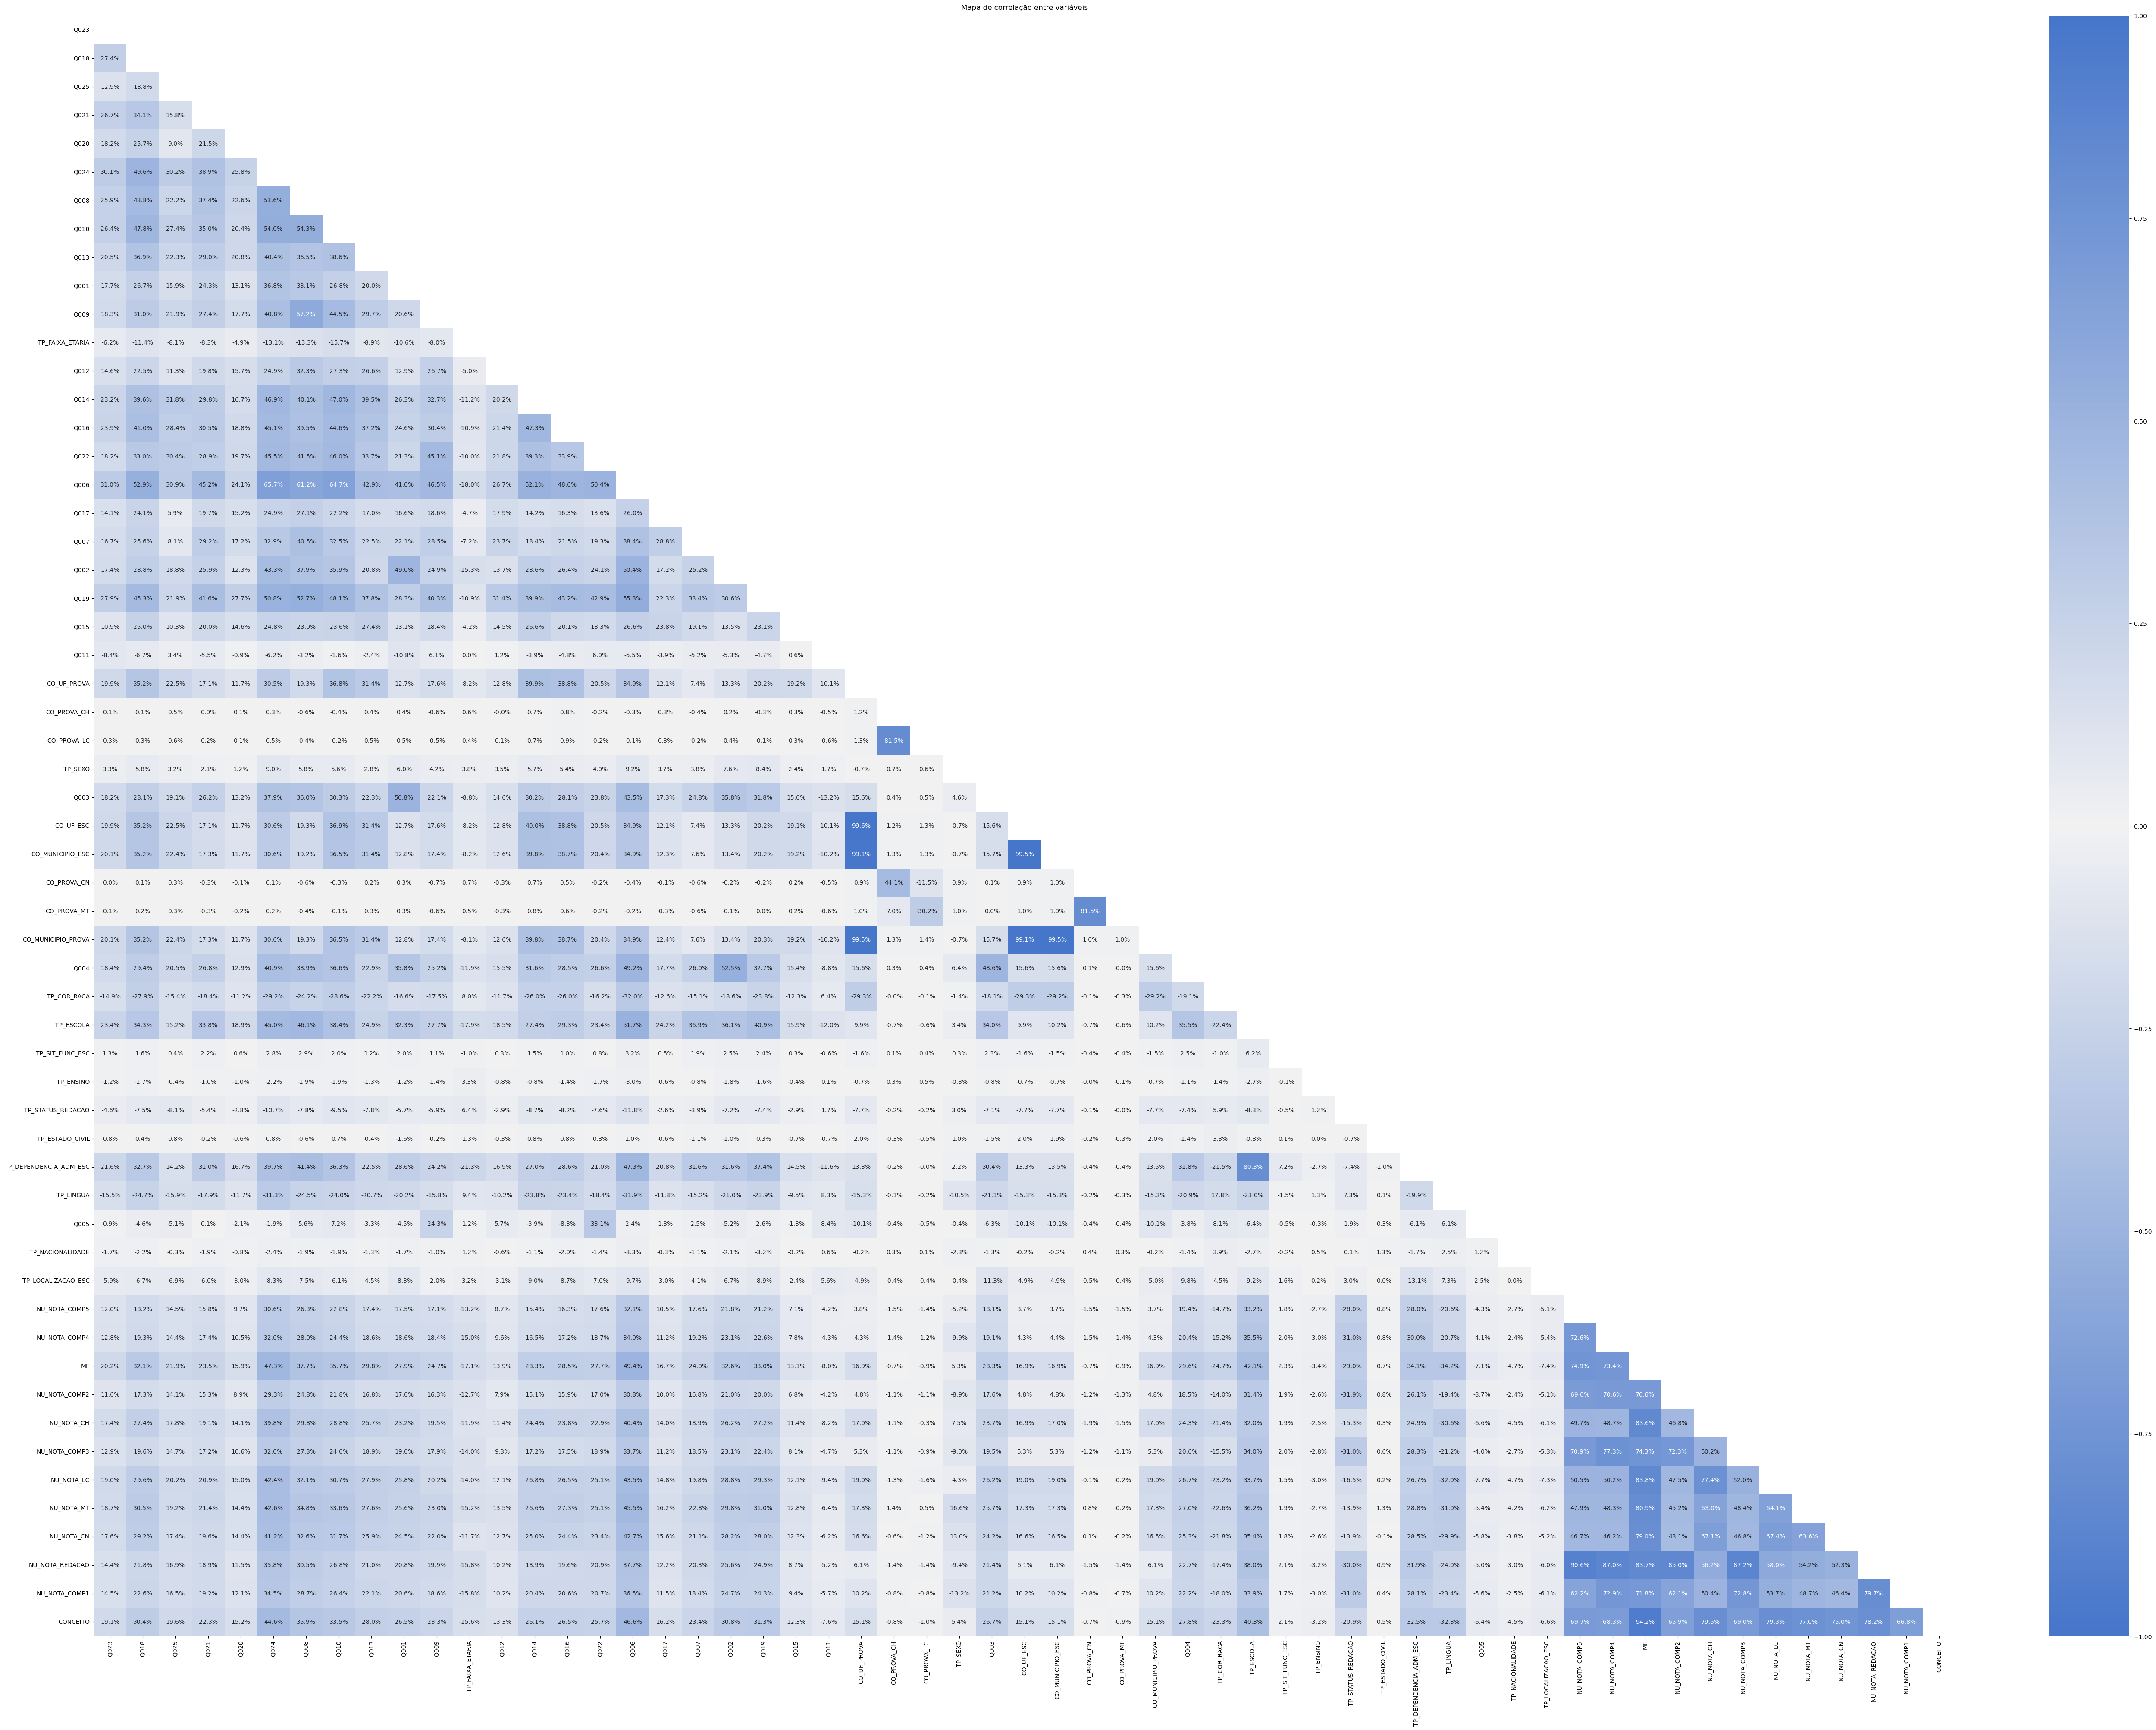

In [19]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

- **Variáveis altamente correlacionadas:** CO_MUNICIPIO_ESC, CO_MUNICIPIO_PROVA

In [20]:
drop_features3 = ['CO_MUNICIPIO_ESC', 'CO_MUNICIPIO_PROVA']

train_data = train_data.drop(columns=drop_features3)
train_data_as_num = train_data_as_num.drop(columns=drop_features3)
train_data_as_num.head()

,Q023,Q018,Q025,Q021,Q020,Q024,Q008,Q010,Q013,Q001,...,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1,CONCEITO
0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,...,608.46,200.0,503.4,120.0,498.0,725.3,595.6,720.0,120.0,2
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,...,362.88,0.0,477.3,0.0,418.4,475.1,443.6,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,3.0,...,681.82,200.0,601.2,160.0,590.4,702.6,594.9,920.0,160.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,462.20,120.0,487.3,80.0,519.7,405.9,478.1,420.0,120.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,...,506.72,120.0,415.9,120.0,532.7,580.2,364.8,640.0,120.0,1


In [21]:
boolean_features = list(set(boolean_features) - set(drop_features3))
ordinal_features = list(set(ordinal_features) - set(drop_features3))
nominal_features = list(set(nominal_features) - set(drop_features3))
discrete_features = list(set(discrete_features) - set(drop_features3))
continuous_features = list(set(continuous_features) - set(drop_features3))
label_features = list(set(label_features) - set(drop_features3))
all_features = list(set(all_features) - set(drop_features3))

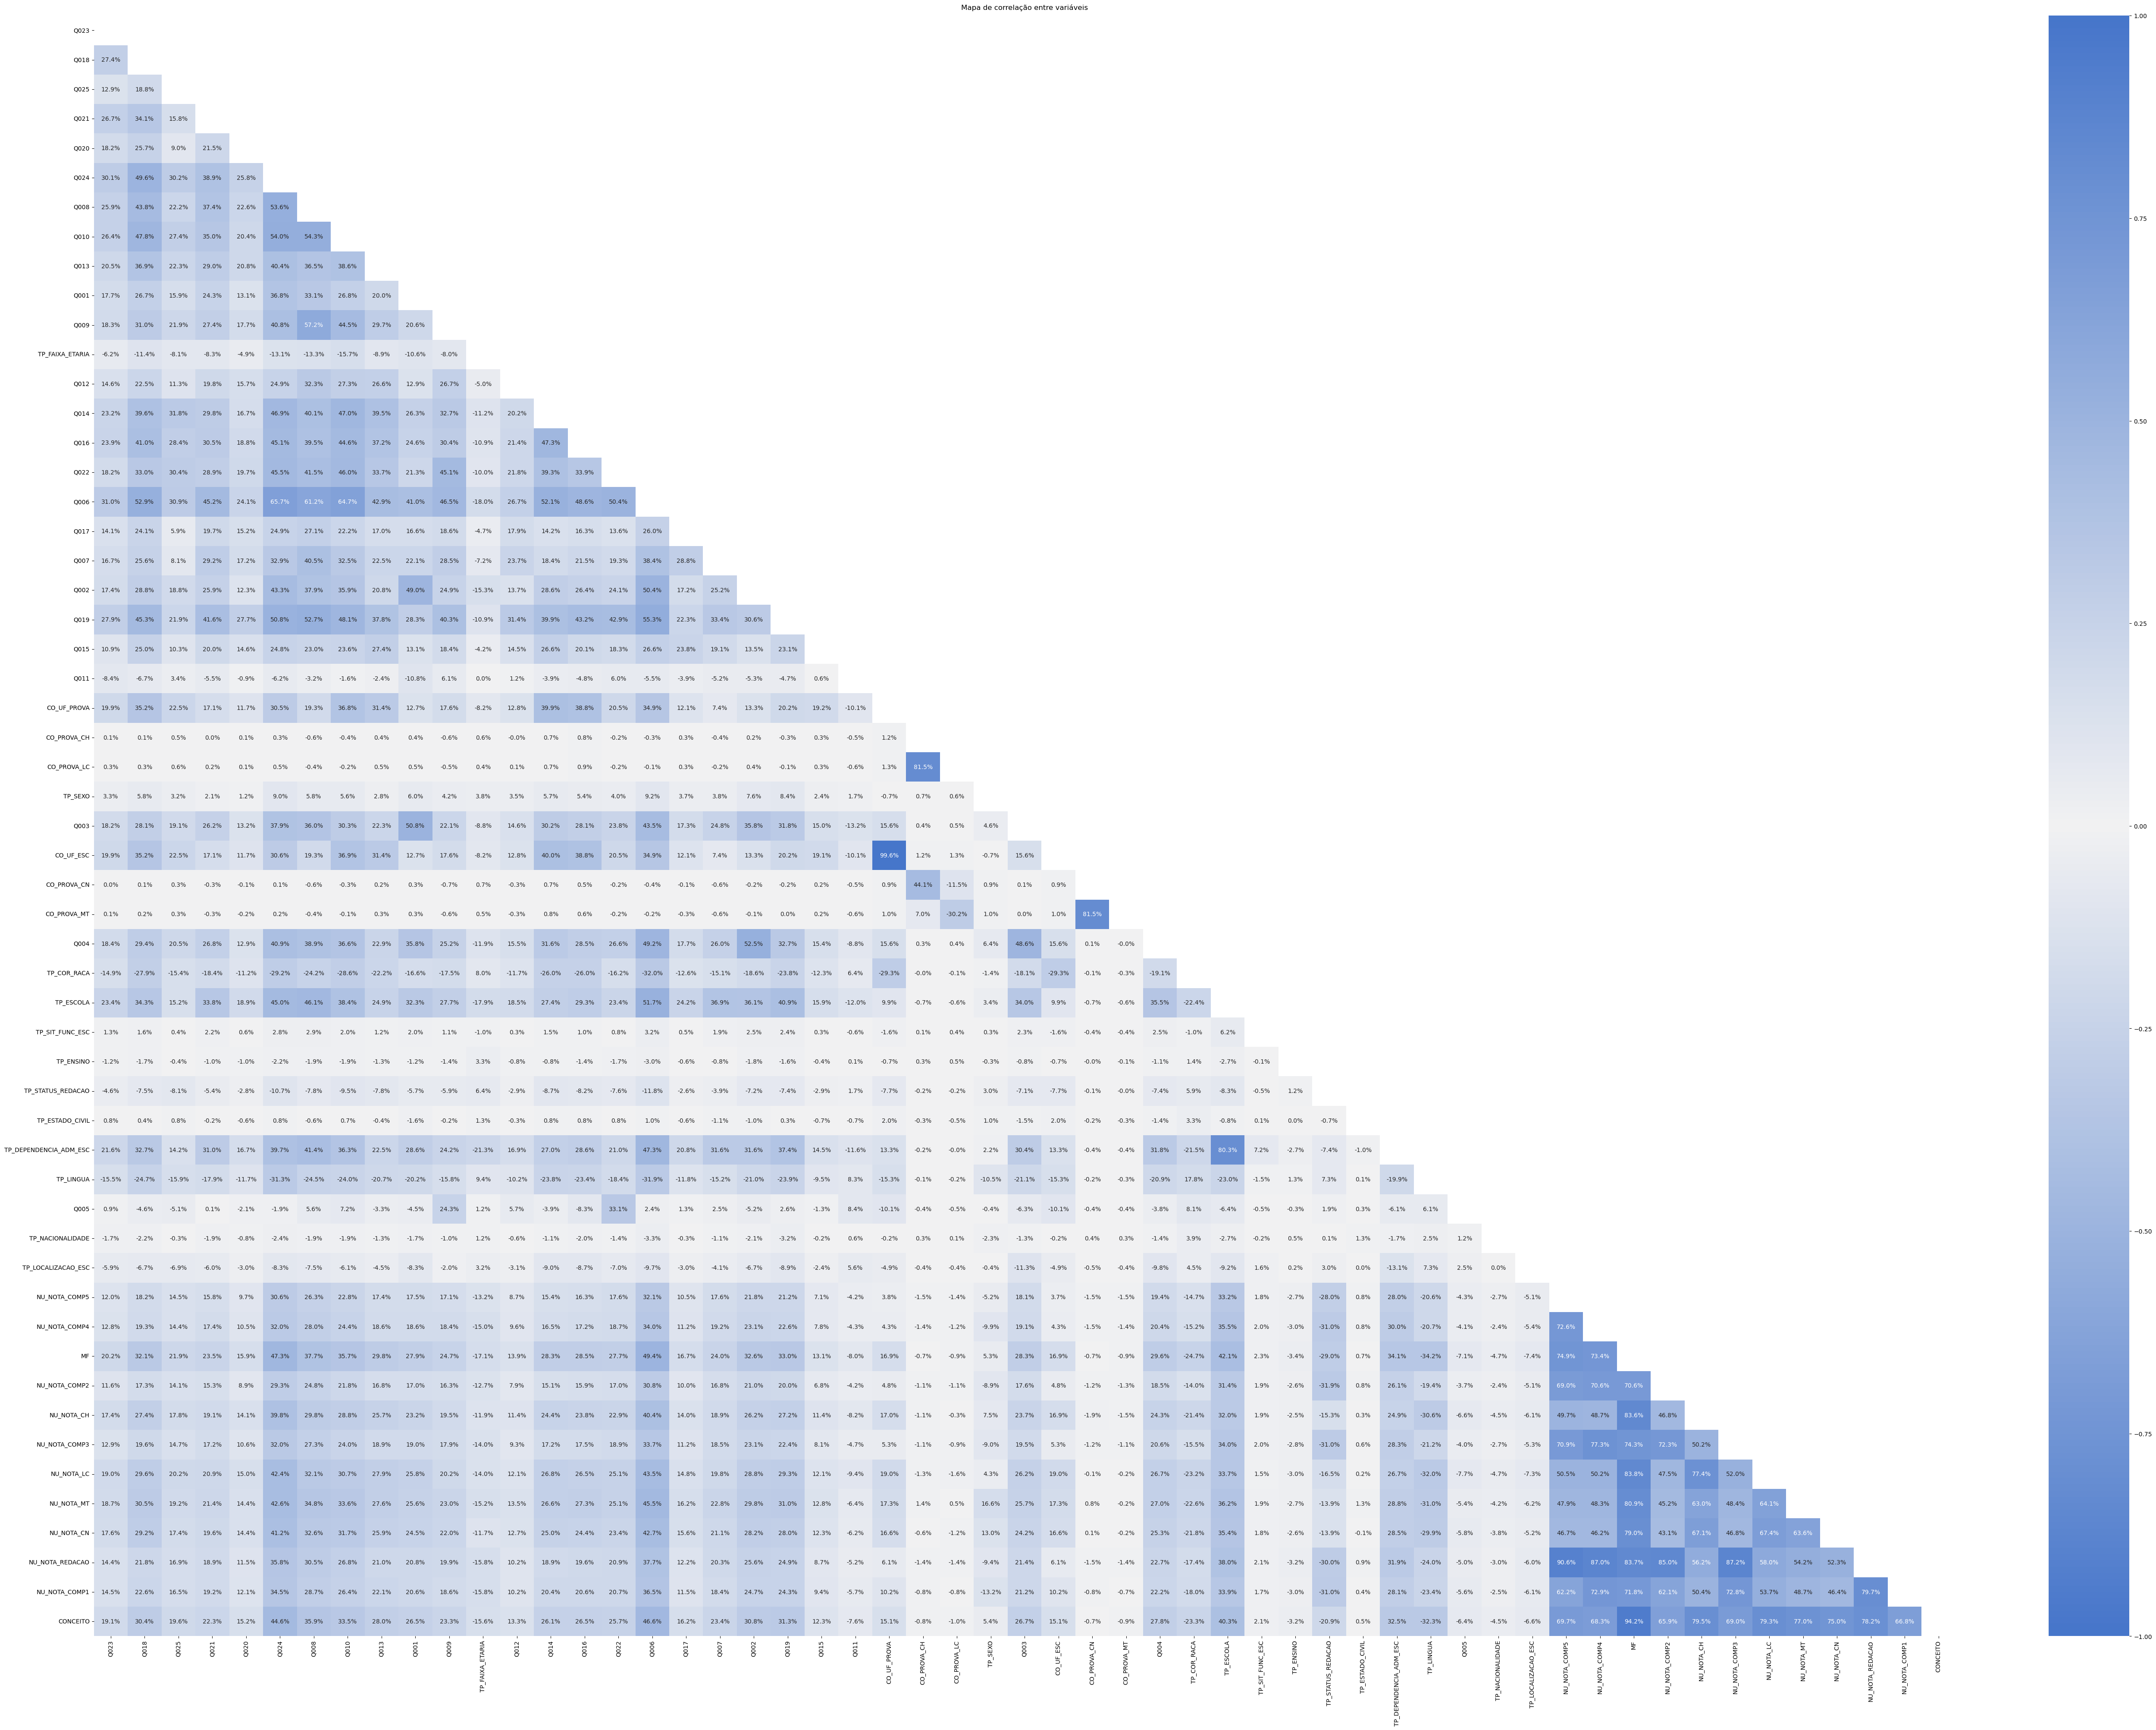

In [22]:
fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


def plot(ax, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
    graph.set_title(title, pad=10)


plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
plt.show()

- **Variáveis com data leaking:** CO_PROVA_CN, CO_PROVA_MT, CO_PROVA_CH, CO_PROVA_LC, NU_NOTA_MT, MF, NU_NOTA_COMP2, NU_NOTA_CH, NU_NOTA_COMP1, NU_NOTA_REDACAO, NU_NOTA_COMP4, NU_NOTA_LC, NU_NOTA_COMP3, NU_NOTA_CN, NU_NOTA_COMP5, TP_LINGUA, TP_STATUS_REDACAO

In [23]:
# drop_features4 = ['CO_PROVA_CN', 'CO_PROVA_MT', 'CO_PROVA_CH', 'CO_PROVA_LC', 'NU_NOTA_MT', 'MF', 'NU_NOTA_COMP2', 'NU_NOTA_CH', 'NU_NOTA_COMP1', 'NU_NOTA_REDACAO', 'NU_NOTA_COMP4', 'NU_NOTA_LC', 'NU_NOTA_COMP3', 'NU_NOTA_CN', 'NU_NOTA_COMP5', 'TP_LINGUA', 'TP_STATUS_REDACAO']

# train_data = train_data.drop(columns=drop_features4)
# train_data_as_num = train_data_as_num.drop(columns=drop_features4)
# train_data_as_num.head()

In [24]:
# boolean_features = list(set(boolean_features) - set(drop_features4))
# ordinal_features = list(set(ordinal_features) - set(drop_features4))
# nominal_features = list(set(nominal_features) - set(drop_features4))
# discrete_features = list(set(discrete_features) - set(drop_features4))
# continuous_features = list(set(continuous_features) - set(drop_features4))
# label_features = list(set(label_features) - set(drop_features4))

In [25]:
# fig, ax = plt.subplots(figsize=(50, 40), constrained_layout=True)


# def plot(ax, data, title):
#     corr = data.corr(method='spearman')
#     cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
#     mask = np.triu(np.ones_like(corr, dtype=bool))

#     graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=ax)
#     graph.set_title(title, pad=10)


# plot(ax, train_data_as_num, 'Mapa de correlação entre variáveis')
# plt.show()

In [26]:
X_as_num, y_as_num = get_X_y(train_data_as_num)

## **Seleção do modelo**

In [27]:
X_preprocessor, y_preprocessor = get_preprocessors()

In [28]:
X = pd.DataFrame(X, columns=X_as_num.columns)
X_as_num = preprocess_X(X, X_preprocessor)
X_as_num.head()

,Q023,Q018,Q025,Q021,Q020,Q008,Q009,Q012,Q006,Q017,...,NU_NOTA_COMP4,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1
0,0.0,1.0,1.0,0.0,0.0,2.0,3.0,1.0,7.0,0.0,...,140.0,608.46,200.0,503.4,120.0,498.0,725.3,595.6,720.0,120.0
1,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,...,0.0,362.88,0.0,477.3,0.0,418.4,475.1,443.6,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,3.0,0.0,...,200.0,681.82,200.0,601.2,160.0,590.4,702.6,594.9,920.0,160.0
3,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,...,100.0,462.20,120.0,487.3,80.0,519.7,405.9,478.1,420.0,120.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,...,120.0,506.72,120.0,415.9,120.0,532.7,580.2,364.8,640.0,120.0


In [29]:
svc_model = SVC(random_state=SEED)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_as_num, y_as_num, train_size=0.8, random_state=SEED)

In [31]:
svc_model.fit(X_train, y_train)

SVC(random_state=3)

In [32]:
svc_val_predictions = svc_model.predict(X_val)

In [33]:
print(f'Accuracy: {accuracy_score(y_val, svc_val_predictions)}')

Accuracy: 0.9961908435593915


In [ ]:
svc_scores = cross_val_score(svc_model, X_as_num, y_as_num, cv=5, scoring='accuracy')
svc_scores.mean()

# **Predição**

In [34]:
test_data

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_MUNICIPIO_ESC,...,Q019,Q020,Q021,Q022,Q023,Q024,Q025,ID,MF,NU_ANO
0,3,F,1,1,1,2,3,1.0,0,3167202.0,...,C,A,A,E,A,B,B,1522973,676.94,2020
1,2,F,1,1,1,2,3,1.0,0,3547809.0,...,B,A,A,B,A,B,B,797399,569.28,2020
2,2,F,1,3,1,2,2,1.0,0,3527405.0,...,B,A,B,E,A,B,B,20668,539.44,2020
3,2,M,1,5,1,2,2,1.0,0,2105203.0,...,B,A,A,D,A,A,B,2403460,459.18,2020
4,2,F,1,1,1,2,3,1.0,0,5208707.0,...,C,B,B,C,A,B,B,1688333,687.24,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88877,3,F,1,3,1,2,2,1.0,0,1504208.0,...,B,A,B,E,A,A,B,1469881,449.18,2020
88878,4,M,1,1,1,2,2,1.0,0,3506359.0,...,C,B,B,E,A,C,B,622036,610.94,2020
88879,3,F,1,3,1,2,2,1.0,0,3304557.0,...,D,A,A,E,A,C,B,1398519,523.42,2020
88880,3,M,2,2,1,2,2,1.0,0,3302205.0,...,C,B,A,E,A,A,B,397766,366.60,2020


In [35]:
def order_X_test(X_test, X_train):
    return pd.DataFrame(X_test, columns=X_train.columns)

X_test = order_X_test(test_data, X_train)
X_test.head()

,Q023,Q018,Q025,Q021,Q020,Q008,Q009,Q012,Q006,Q017,...,NU_NOTA_COMP4,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1
0,A,A,B,A,A,D,D,B,M,A,...,180.0,676.94,180.0,631.6,160.0,611.9,694.0,607.2,840.0,160.0
1,A,A,B,A,A,B,C,B,F,A,...,180.0,569.28,200.0,510.6,160.0,503.8,463.9,488.1,880.0,160.0
2,A,A,B,B,A,C,D,B,E,A,...,120.0,539.44,160.0,539.3,120.0,567.0,454.3,456.6,680.0,120.0
3,A,A,B,A,A,B,C,B,D,A,...,80.0,459.18,100.0,439.1,80.0,478.0,448.3,470.5,460.0,80.0
4,A,B,B,B,B,E,E,B,M,A,...,160.0,687.24,200.0,626.4,180.0,579.7,739.4,610.7,880.0,140.0


In [36]:
X_test = X_preprocessor.transform(test_data)
X_test = pd.DataFrame(X_test, columns=get_preprocessor_feature_names(X_preprocessor, X_test))
X_test

,Q023,Q018,Q025,Q021,Q020,Q008,Q009,Q012,Q006,Q017,...,NU_NOTA_COMP4,MF,NU_NOTA_COMP2,NU_NOTA_CH,NU_NOTA_COMP3,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_REDACAO,NU_NOTA_COMP1
0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,1.0,12.0,0.0,...,180.0,676.94,180.0,631.6,160.0,611.9,694.0,607.2,840.0,160.0
1,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,5.0,0.0,...,180.0,569.28,200.0,510.6,160.0,503.8,463.9,488.1,880.0,160.0
2,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,4.0,0.0,...,120.0,539.44,160.0,539.3,120.0,567.0,454.3,456.6,680.0,120.0
3,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,3.0,0.0,...,80.0,459.18,100.0,439.1,80.0,478.0,448.3,470.5,460.0,80.0
4,0.0,1.0,1.0,1.0,1.0,4.0,4.0,1.0,12.0,0.0,...,160.0,687.24,200.0,626.4,180.0,579.7,739.4,610.7,880.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88877,0.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,5.0,0.0,...,120.0,449.18,120.0,394.5,120.0,441.7,449.5,400.2,560.0,100.0
88878,0.0,0.0,1.0,1.0,1.0,1.0,3.0,1.0,4.0,0.0,...,120.0,610.94,140.0,638.7,140.0,568.1,621.2,586.7,640.0,140.0
88879,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,...,120.0,523.42,160.0,511.8,120.0,448.0,591.5,445.8,620.0,120.0
88880,0.0,0.0,1.0,0.0,1.0,1.0,3.0,2.0,5.0,0.0,...,0.0,366.60,0.0,502.8,0.0,415.5,442.4,472.3,0.0,0.0


In [41]:
test_predictions = svc_model.predict(X_test)

In [42]:
submission_df = pd.DataFrame(test_predictions, index=test_data['ID'], columns=['Category'])
submission_df = translate_y(submission_df, y_preprocessor)
submission_df.head()

,Category
ID,
1522973,C
797399,D
20668,D
2403460,E
1688333,C


In [43]:
submission_df.to_csv('submission.csv')